In [1]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from data_transform import *
from plots import *

In [2]:
X_0 = pd.read_csv('./data/train.csv', nrows=100)

In [15]:
Y = pd.read_csv('./data/challenge_output_data_training_file_nba_challenge.csv', sep = ';',)

## Multi-indexing

In [3]:
# building multi-index
X_1 = X_0.drop('ID', 1)
cols = X_1.columns.tolist()
multi_index = [(c.split('_')[0], int(c.split('_')[1])) for c in cols]

In [4]:
index = pd.MultiIndex.from_tuples(multi_index)
X = X_1.copy()
X.columns = index

In [5]:
X_stacked = X.stack()
X_stacked = X_stacked.drop('defensive foul', 1) # always equal to 0

In [6]:
N = X_1.shape[0]
T = X_stacked.loc[0].shape[0]
original_feats = X_stacked.columns.tolist()

In [7]:
# avoiding to consume too much memory
del X_1
del X

In [8]:
X_stacked.head(3)

assist  bad pass  block  defensive rebound  lost ball  miss  \
0 1       0         0      0                  0          0     0   
  2       0         0      0                  0          0     0   
  3       0         0      0                  0          0     0   

     offensive foul  offensive rebound  score  steals  
0 1               0                  0     -2       0  
  2               0                  0     -2       0  
  3               0                  0     -2       0

In [9]:
X_stacked.loc[3, 10] # game 3, second 10

assist               0
bad pass             0
block                0
defensive rebound    0
lost ball            0
miss                 0
offensive foul       0
offensive rebound    0
score               -2
steals               0
Name: (3, 10), dtype: int64

# Getting stats back from differences

We compute the instant features from each event, for instance ```score_inst[t]``` will be equal to ```score[t+1] - score[t]```

In [10]:
X_inst = compute_instant_stats(X_stacked, original_feats)

In [11]:
X_inst.head(3)

assist  bad pass  block  defensive rebound  lost ball  miss  \
0 1       0         0      0                  0          0     0   
  2       0         0      0                  0          0     0   
  3       0         0      0                  0          0     0   

     offensive foul  offensive rebound  score  steals  assist_inst  \
0 1               0                  0     -2       0            0   
  2               0                  0     -2       0            0   
  3               0                  0     -2       0            0   

     bad pass_inst  block_inst  defensive rebound_inst  lost ball_inst  \
0 1              0           0                       0               0   
  2              0           0                       0               0   
  3              0           0                       0               0   

     miss_inst  offensive foul_inst  offensive rebound_inst  score_inst  \
0 1          0                    0                       0          -2   
  2          0                    0                       0           0   
  3          0                    0                       0           0   

     steals_inst  
0 1            0  
  2            0  
  3            0

# Cleaning data

Removing games with less than 30 score changes (almost surely incomplete information):

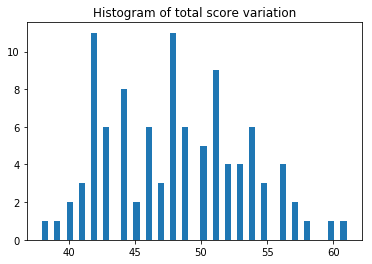

In [12]:
# remove games with too little data
score_count = X_inst[X_inst['score_inst'] != 0].groupby(level = 0).count()['score']
plt.hist(score_count, bins = 50)
plt.title('Histogram of total score variation')
plt.show()

For instance, the following game clearly has to be removed:

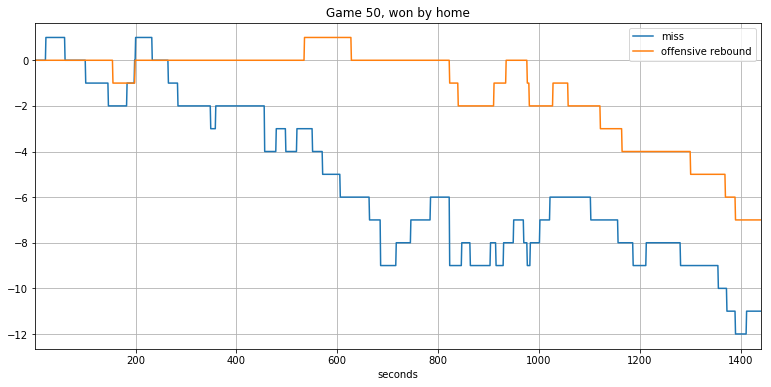

In [20]:
plot_game(X_inst, Y, 50, events = ['miss', 'offensive rebound'])#, 'assist', 'miss', 'lost ball'])

In [14]:
X_unstacked = X_inst.unstack()

In [26]:
X_unstacked['score_count'] = score_count
X_unstacked = X_unstacked[X_unstacked['score_count'] > 30]

In [27]:
Y_new = Y.loc[X_unstacked.index.tolist()]

**Now removing noise in score data:**

Some games have a high variation in score (+13/-13 in less than two seconds) that has to be taken into account as noise and removed. The function ```denoise_scores()``` removes any variation in the score higher than a certain treshold.

In [28]:
score_matrix = X_unstacked['score'].as_matrix()

In [29]:
scores_denoised = denoise_scores(score_matrix, 5)

Processing row 0/12499
Processing row 1000/12499
Processing row 2000/12499
Processing row 3000/12499
Processing row 4000/12499
Processing row 5000/12499
Processing row 6000/12499
Processing row 7000/12499
Processing row 8000/12499
Processing row 9000/12499
Processing row 10000/12499
Processing row 11000/12499
Processing row 12000/12499


In [30]:
X_unstacked['score'] = scores_denoised

In [ ]:
X_denoised = X_unstacked.stack()

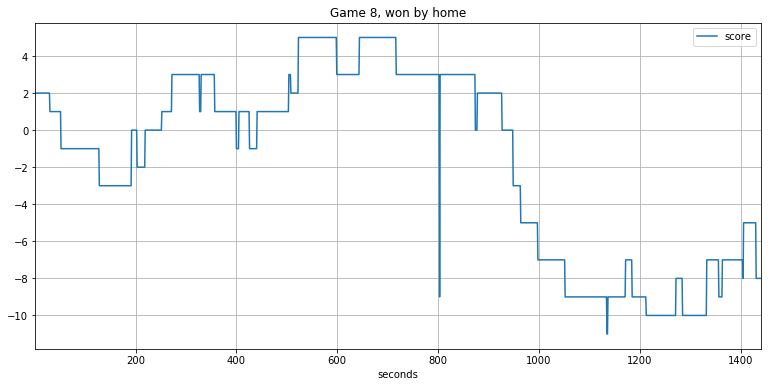

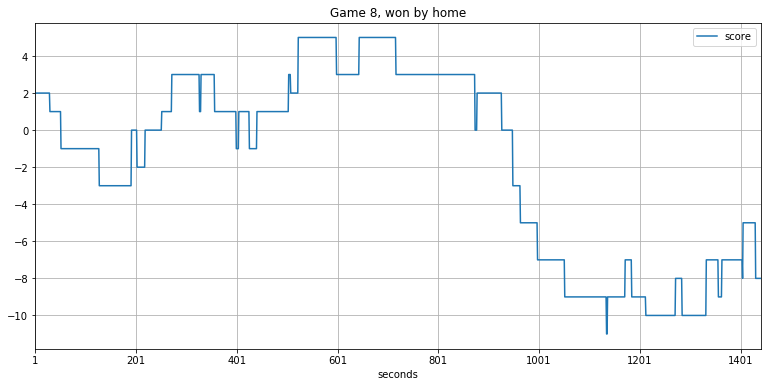

In [22]:
# before
plot_game(X_inst, Y, 8, ['score'])

# after
plot_game(X_denoised, Y, 8, ['score'])

In [29]:
X_unstacked.head()

assist                                ...     steals_inst                 \
       1  2  3  4  5  6  7  8  9 10     ...            1432 1433 1434 1435   
0      0  0  0  0  0  0  0  0  0  0     ...               0    0    0    0   
1      0  0  0  0  0  0  0  0  0  0     ...               0    0    0    0   
2      0  0  0  0  0  0  0  0  0  0     ...               0    0    0    0   
3      0  0  0  0  0  0  0  0  0  0     ...               0    0    0    0   
4      0  0  0  0  0  0  0  0  0  0     ...               0    0    0    0   

                           score_count  
  1436 1437 1438 1439 1440              
0    0    0    0    0    0        45.0  
1    0    0    0    0    0        50.0  
2    0    1    0    0    0        48.0  
3    0    0    0    0    0        51.0  
4    0   -1    0    0    0        53.0  

[5 rows x 28801 columns]

In [31]:
X_denoised.head()

assist  bad pass  block  defensive rebound  lost ball  miss  \
0 1     0.0       0.0    0.0                0.0        0.0   0.0   
  2     0.0       0.0    0.0                0.0        0.0   0.0   
  3     0.0       0.0    0.0                0.0        0.0   0.0   
  4     0.0       0.0    0.0                0.0        0.0   0.0   
  5     0.0       0.0    0.0                0.0        0.0   0.0   

     offensive foul  offensive rebound  score  steals     ...       \
0 1             0.0                0.0   -2.0     0.0     ...        
  2             0.0                0.0   -2.0     0.0     ...        
  3             0.0                0.0   -2.0     0.0     ...        
  4             0.0                0.0   -2.0     0.0     ...        
  5             0.0                0.0   -2.0     0.0     ...        

     bad pass_inst  block_inst  defensive rebound_inst  lost ball_inst  \
0 1            0.0         0.0                     0.0             0.0   
  2            0.0         0.0                     0.0             0.0   
  3            0.0         0.0                     0.0             0.0   
  4            0.0         0.0                     0.0             0.0   
  5            0.0         0.0                     0.0             0.0   

     miss_inst  offensive foul_inst  offensive rebound_inst  score_inst  \
0 1        0.0                  0.0                     0.0        -2.0   
  2        0.0                  0.0                     0.0         0.0   
  3        0.0                  0.0                     0.0         0.0   
  4        0.0                  0.0                     0.0         0.0   
  5        0.0                  0.0                     0.0         0.0   

     steals_inst  score_count  
0 1          0.0          NaN  
  2          0.0          NaN  
  3          0.0          NaN  
  4          0.0          NaN  
  5          0.0          NaN  

[5 rows x 21 columns]

In [33]:
Y_new.head()

,ID,label
0,14186,0
1,13013,0
2,7102,0
3,7637,1
4,12350,0


## Computing basic features

### 1. Aggregating totals

In [34]:
X_feats = pd.DataFrame(index = X_unstacked.index)

In [35]:
def compute_total(df_time, df_feats, play):
    """computes the total number of a given play for each team. 
    Args
        df_time: the dataframe with the play-by-play instant values
        df_feats: the target dataframe where to store the total
        play: name of play to sum, such as 'score', 'steals'..
    Returns
        df_completed: the dataframe df_feats with two additional columns
            corresponding to the total of plays for each team. For instance,
            if play = 'score', then df_completed will have two columns 
            'score_total_visitor' and 'score_total_home' with the total score of
            the visiting and home team
    """
    
    visitor = np.maximum(df_time[play + '_inst'], 0).cumsum(level = [0])
    df_feats[play + '_total_visitor'] = visitor
    
    home = np.maximum(- df_time[play + '_inst'], 0).cumsum(level = [0])
    df_feats[play + '_total_home'] = home
    
    return df_feats

In [37]:
for play in original_feats:
    X_feats = compute_total(X_denoised, X_feats, play)

In [39]:
X_feats.head(3)

,assist_total_visitor,assist_total_home,bad pass_total_visitor,bad pass_total_home,block_total_visitor,block_total_home,defensive rebound_total_visitor,defensive rebound_total_home,lost ball_total_visitor,lost ball_total_home,miss_total_visitor,miss_total_home,offensive foul_total_visitor,offensive foul_total_home,offensive rebound_total_visitor,offensive rebound_total_home,score_total_visitor,score_total_home,steals_total_visitor,steals_total_home
0,8.0,11.0,1.0,3.0,3.0,2.0,15.0,19.0,6.0,3.0,30.0,21.0,2.0,0.0,9.0,1.0,41.0,54.0,5.0,2.0
1,13.0,12.0,4.0,3.0,2.0,4.0,17.0,12.0,2.0,2.0,22.0,23.0,0.0,0.0,7.0,6.0,49.0,54.0,5.0,5.0
2,9.0,9.0,3.0,5.0,3.0,0.0,13.0,18.0,5.0,0.0,16.0,21.0,0.0,5.0,4.0,5.0,55.0,50.0,7.0,2.0


### 2. Basic features

In [40]:
## REBOUNDS

X_feats['all_rebounds_visitor'] = X_feats['offensive rebound_total_visitor'] \
    + X_feats['defensive rebound_total_visitor']

X_feats['all_rebounds_home'] = X_feats['offensive rebound_total_home'] \
    + X_feats['defensive rebound_total_home']

X_feats['total_rebounds'] = X_feats['all_rebounds_home'] + X_feats['all_rebounds_visitor']

# rebound ratio
for team in ['visitor', 'home']:
    X_feats['rebound_ratio_' + team] = X_feats['all_rebounds_' + team] \
        / X_feats['total_rebounds']

In [21]:
## NUMBER OF BASKETS


In [307]:
## PASSES
# ratio assist to baskets ?